# PROJECT B : Analisis Sinyal Gempa Palu Pada Tahun 2018 Menggunakan Python ObsPy

### Nama : Syawal Adrian Syah <br>
### NIM  : 1306622023 
### Mata Kuliah : Analisis Sinyal Digital

In [1]:
import os
import numpy as np
from obspy import UTCDateTime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from obspy.clients.fdsn import Client
from obspy.core.event import Catalog, Event, Origin, Magnitude
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from obspy.geodetics import locations2degrees, gps2dist_azimuth

In [2]:
#  Persiapan Folder Output 
os.makedirs("output/figures", exist_ok=True)

In [3]:
#  Koneksi ke Server GEOFON 
client = Client("geofon")
print("Terhubung ke server GEOFON")

Terhubung ke server GEOFON


In [4]:
#  Informasi Gempa Palu 2018 
print("Analisis Gempa Palu 2018")
ev_time = UTCDateTime("2018-09-28T10:03:00")
ev_lat, ev_lon, ev_depth = -0.178, 119.840, 10000  # kedalaman 10 km

#  Definisi Event Manual
origin = Origin(time=ev_time, latitude=ev_lat, longitude=ev_lon, depth=ev_depth)
magnitude = Magnitude(mag=7.5, magnitude_type="Mw")
ev = Event(origins=[origin], magnitudes=[magnitude])

Analisis Gempa Palu 2018


In [5]:
# Ambil daftar semua stasiun jaringan GE 
print(" Mengambil daftar stasiun GEOFON ...")
inv_all = client.get_stations(network="GE", level="station")

# Temukan stasiun terdekat dari episenter gempa 
min_dist_km = float("inf")
closest_station = None
closest_lat, closest_lon = None, None

for net in inv_all:
    for sta in net:
        dist_m, az, baz = gps2dist_azimuth(ev_lat, ev_lon, sta.latitude, sta.longitude)
        dist_km = dist_m / 1000.0
        if dist_km < min_dist_km:
            min_dist_km = dist_km
            closest_station = sta.code
            closest_lat = sta.latitude
            closest_lon = sta.longitude

print(f"Stasiun terdekat: GE.{closest_station}")
print(f"Lokasi: ({closest_lat:.3f}, {closest_lon:.3f}) — Jarak {min_dist_km:.1f} km dari episenter")

 Mengambil daftar stasiun GEOFON ...
Stasiun terdekat: GE.TOLI2
Lokasi: (1.111, 120.782) — Jarak 176.9 km dari episenter


In [6]:
#  Ambil Data dari Stasiun GEOFON di Indonesia 
network = "GE"
station = "TOLI2"    # Stasiun GEOFON Sulawesi Tengah, Indonesia
location = ""
channel = "BHZ"

t1 = ev_time - 60
t2 = ev_time + 900

print(f"Mengunduh waveform dari stasiun {network}.{station} (Sulawesi Tengah, Indonesia)...")
st = client.get_waveforms(network, station, location, channel, t1, t2)
print(st)

Mengunduh waveform dari stasiun GE.TOLI2 (Sulawesi Tengah, Indonesia)...
1 Trace(s) in Stream:
GE.TOLI2..BHZ | 2018-09-28T10:02:00.019538Z - 2018-09-28T10:18:00.019538Z | 20.0 Hz, 19201 samples


In [7]:
tr = st[0]
amp_max = abs(tr.data).max()
rms_val = np.sqrt(np.nanmean(tr.data**2))
duration = tr.stats.endtime - tr.stats.starttime

print("\n--- METADATA SEISMO ---")
print(f"Stasiun        : {tr.stats.network}.{tr.stats.station}")
print(f"Lokasi / Kanal : {tr.stats.location}.{tr.stats.channel}")
print(f"Sampling rate  : {tr.stats.sampling_rate} Hz")
print(f"Waktu mulai    : {tr.stats.starttime}")
print(f"Waktu akhir    : {tr.stats.endtime}")
print(f"Jumlah data    : {len(tr.data)} sample")
print("\n--- ANALISIS SINYAL ---")
print(f"Amplitudo maksimum : {amp_max:.2f}")
print(f"RMS (energi rata-rata): {rms_val:.2f}")
print(f"Durasi rekaman       : {duration:.1f} detik")


--- METADATA SEISMO ---
Stasiun        : GE.TOLI2
Lokasi / Kanal : .BHZ
Sampling rate  : 20.0 Hz
Waktu mulai    : 2018-09-28T10:02:00.019538Z
Waktu akhir    : 2018-09-28T10:18:00.019538Z
Jumlah data    : 19201 sample

--- ANALISIS SINYAL ---
Amplitudo maksimum : 6461048.00
RMS (energi rata-rata): 4768.61
Durasi rekaman       : 960.0 detik


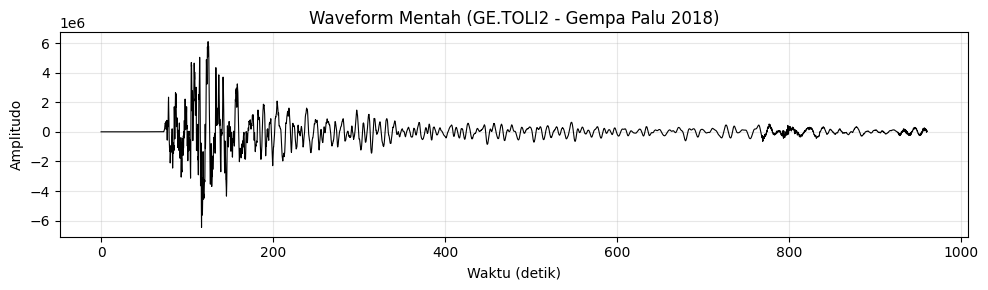

In [8]:
#  Plot Waveform Mentah 
tr = st[0]
t = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts)

plt.figure(figsize=(10,3))
plt.plot(t, tr.data, color='black', lw=0.8)
plt.title(f"Waveform Mentah ({network}.{station} - Gempa Palu 2018)")
plt.xlabel("Waktu (detik)")
plt.ylabel("Amplitudo")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("output/figures/00_waveform.png", dpi=200)
plt.show()


C:\Users\Syawal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\obspy\signal\filter.py:62: UserWarning: Selected high corner frequency (10) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


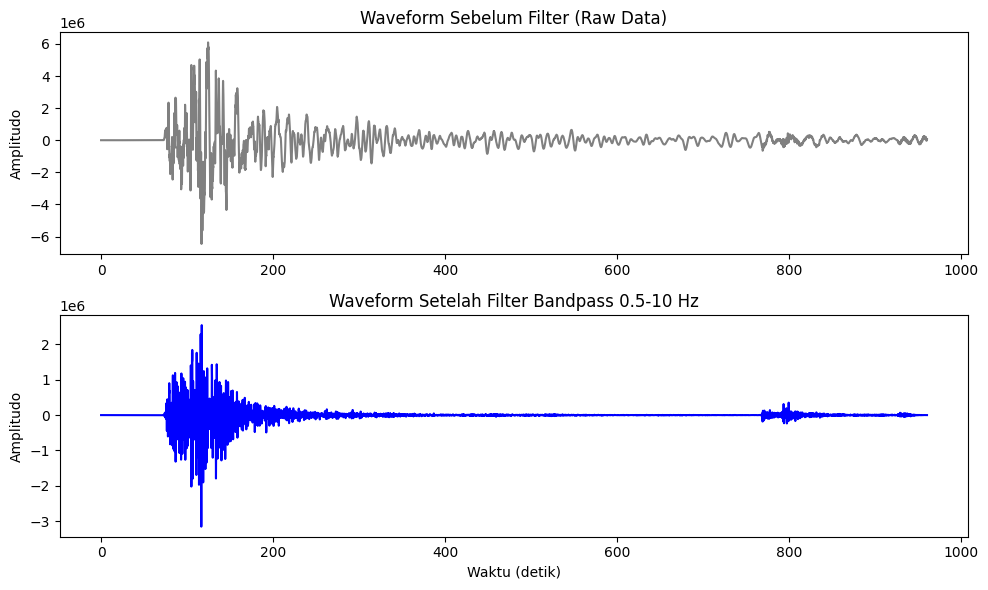

In [9]:
#  Filtering (0.5–10 Hz) 
st_filt = st.copy()
st_filt.detrend("demean")
st_filt.taper(max_percentage=0.05, type="hann")
st_filt.filter("bandpass", freqmin=0.5, freqmax=10)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(st[0].times(), st[0].data, color='gray')
plt.title("Waveform Sebelum Filter (Raw Data)")
plt.ylabel("Amplitudo")

plt.subplot(2,1,2)
plt.plot(st_filt[0].times(), st_filt[0].data, color='blue')
plt.title("Waveform Setelah Filter Bandpass 0.5-10 Hz")
plt.xlabel("Waktu (detik)")
plt.ylabel("Amplitudo")
plt.tight_layout()
plt.savefig("output/figures/01_waveform_filter.png", dpi=200)
plt.show()

Gambar di atas memperlihatkan perbandingan waveform sebelum (atas) dan sesudah (bawah) dilakukan proses filtering. Pada waveform mentah (raw data), sinyal masih mengandung banyak noise dengan variasi amplitudo yang tidak stabil. Di awal rekaman, terlihat osilasi acak yang bukan berasal dari gelombang gempa, sedangkan bagian tengah hingga akhir sinyal relatif datar dengan fluktuasi kecil. Sinyal mentah ini sulit untuk diinterpretasikan secara langsung karena dominasi low-frequency drift dan high-frequency noise yang menutupi bentuk gelombang utama. Setelah dilakukan filter detrend, taper 5% dan bandpass 0.5–10 Hz, sinyal menjadi jauh lebih bersih dan struktur gelombang seismik tampak lebih jelas. 
Getaran utama muncul sekitar detik ke-70–250, ditandai oleh peningkatan amplitudo yang signifikan, bagian ini merepresentasikan kedatangan gelombang P dan S dari Gempa Palu 2018.
- Gelombang P (primer) muncul lebih dulu dengan amplitudo yang lebih kecil namun perubahan frekuensi lebih tajam.
- Gelombang S (sekunder) datang beberapa detik kemudian dengan amplitudo lebih besar dan osilasi yang lebih kuat, menandai energi utama gempa yang menyebabkan getaran kuat di permukaan.
Pada rentang waktu setelah 250 detik, amplitudo menurun secara bertahap, yang menandakan fase coda atau sisa getaran yang dihasilkan dari pantulan gelombang di dalam kerak bumi


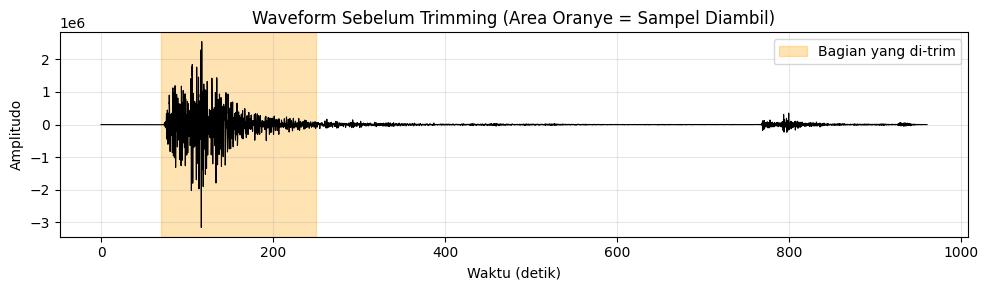

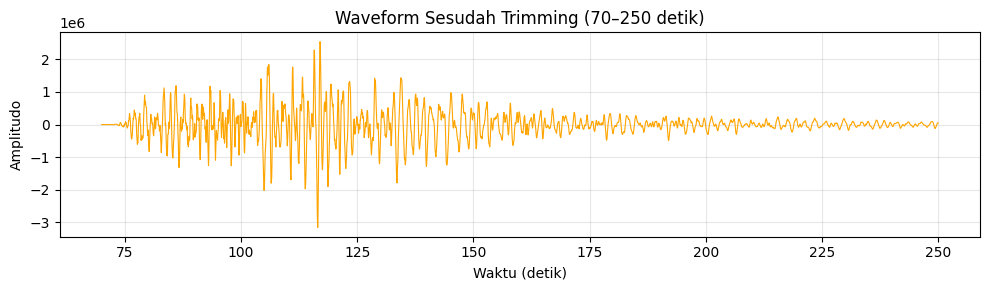

Data berhasil di-trim dari detik 70 sampai 250.


In [10]:
# Tentukan Rentang Waktu Trimming 
t_awal_detik = 70   
t_akhir_detik = 250

# Duplikasi Stream
st_bef = st_filt.copy()

# Hitung Waktu Absolut berdasarkan detik relatif
start_abs = st_filt[0].stats.starttime + t_awal_detik
end_abs   = st_filt[0].stats.starttime + t_akhir_detik

# Lakukan Trimming
st_trim = st_filt.copy().trim(start_abs, end_abs)

# Plot Sebelum Trimming
trb = st_bef[0]
t1 = np.linspace(0, trb.stats.npts / trb.stats.sampling_rate, trb.stats.npts)
plt.figure(figsize=(10,3))
plt.plot(t1, trb.data, lw=0.8, color='black')
plt.axvspan(t_awal_detik, t_akhir_detik, color='orange', alpha=0.3, label='Bagian yang di-trim')
plt.title("Waveform Sebelum Trimming (Area Oranye = Sampel Diambil)")
plt.xlabel("Waktu (detik)")
plt.ylabel("Amplitudo")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("output/figures/02a_wafeform_in_trimming.png", dpi=200)
plt.show()

# Plot Sesudah Trimming
trt = st_trim[0]
t2 = np.linspace(t_awal_detik, t_akhir_detik, trt.stats.npts)
plt.figure(figsize=(10,3))
plt.plot(t2, trt.data, lw=0.8, color="orange")
plt.title(f"Waveform Sesudah Trimming ({t_awal_detik}–{t_akhir_detik} detik)")
plt.xlabel("Waktu (detik)")
plt.ylabel("Amplitudo")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("output/figures/02b_wafeform_trimming.png", dpi=200)
plt.show()

print(f"Data berhasil di-trim dari detik {t_awal_detik} sampai {t_akhir_detik}.")

Berdasarkan hasil trimming waveform pada rentang waktu 70–250 detik, dapat diamati bahwa sinyal seismik menampilkan pola karakteristik yang mencerminkan fase utama gelombang gempa. Pada bagian awal grafik, sekitar detik ke-75 hingga 90, mulai terlihat kenaikan amplitudo pertama yang relatif kecil dan cepat. Bagian ini diinterpretasikan sebagai gelombang P (primer), yaitu gelombang kompresi pertama yang datang paling cepat ke stasiun. Setelah itu, pada kisaran detik ke-100 hingga 130, amplitudo meningkat tajam dan menunjukkan osilasi yang lebih kuat serta lebih kompleks. Puncak amplitudo tertinggi di bagian ini menandakan gelombang S (sekunder), yaitu gelombang geser yang membawa energi lebih besar dibanding gelombang P. Setelah fase gelombang S, amplitudo berangsur menurun hingga sekitar detik ke-200 ke atas, yang menandakan fase coda atau sisa getaran akibat pantulan dan interferensi gelombang di dalam kerak bumi. Hasil trimming ini berhasil memfokuskan analisis pada bagian paling informatif dari sinyal mencakup kedatangan gelombang P, puncak gelombang S, hingga fase peluruhan energi.

Onset terdeteksi pada waktu: 2018-09-28T10:03:24.969538Z
Onset terdeteksi pada waktu: 2018-09-28T10:03:46.119538Z
Onset terdeteksi pada waktu: 2018-09-28T10:04:18.319538Z


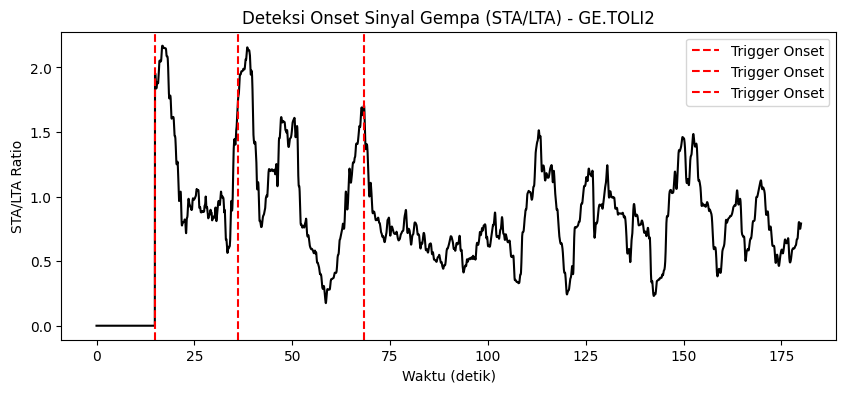

In [11]:
#  Deteksi Onset Gempa (STA/LTA) 
df = st_trim[0].stats.sampling_rate
cft = classic_sta_lta(st_trim[0].data, int(5 * df), int(15 * df))
trig_on = trigger_onset(cft, 1.7, 0.6)

for onset, offset in trig_on:
    onset_time = st_trim[0].stats.starttime + onset / df
    print(f"Onset terdeteksi pada waktu: {onset_time}")

plt.figure(figsize=(10,4))
plt.plot(st_trim[0].times(), cft, color='black')
for onset, offset in trig_on:
    plt.axvline(st_trim[0].times()[onset], color='red', linestyle='--', label='Trigger Onset')
plt.title(f"Deteksi Onset Sinyal Gempa (STA/LTA) - {network}.{station}")
plt.xlabel("Waktu (detik)")
plt.ylabel("STA/LTA Ratio")
plt.legend()
plt.savefig("output/figures/02_sta_lta_trigger.png", dpi=200)
plt.show()

Berdasarkan hasil deteksi STA/LTA (Short-Term Average / Long-Term Average) setelah dilakukan trimming sinyal pada rentang waktu 70–250 detik, diperoleh tiga onset utama yang terdeteksi pada waktu 10:03:24 UTC, 10:03:46 UTC, dan 10:04:18 UTC. Ketiga titik ini merepresentasikan peningkatan rasio STA/LTA yang signifikan akibat kenaikan mendadak energi seismik yang terekam oleh stasiun GE.TOLI2. Onset pertama (10:03:24 UTC) menandakan kedatangan gelombang P (primer), yaitu gelombang kompresi yang merambat paling cepat dari sumber gempa dengan amplitudo yang relatif kecil. Selanjutnya, onset kedua dan ketiga (10:03:46–10:04:18 UTC) menunjukkan peningkatan energi yang lebih besar dan fluktuasi amplitudo yang lebih kompleks, yang diinterpretasikan sebagai gelombang S (sekunder) gelombang geser yang datang setelah gelombang P dengan kecepatan lebih lambat namun membawa energi lebih tinggi. Secara visual pada grafik STA/LTA, ketiga garis vertikal merah menunjukkan titik-titik lonjakan rasio yang jelas terhadap baseline, menggambarkan momen perubahan energi dominan dalam sinyal. Pola ini sesuai dengan teori propagasi gelombang seismik, di mana gelombang P selalu mendahului gelombang S dan disusul oleh fase-fase coda.

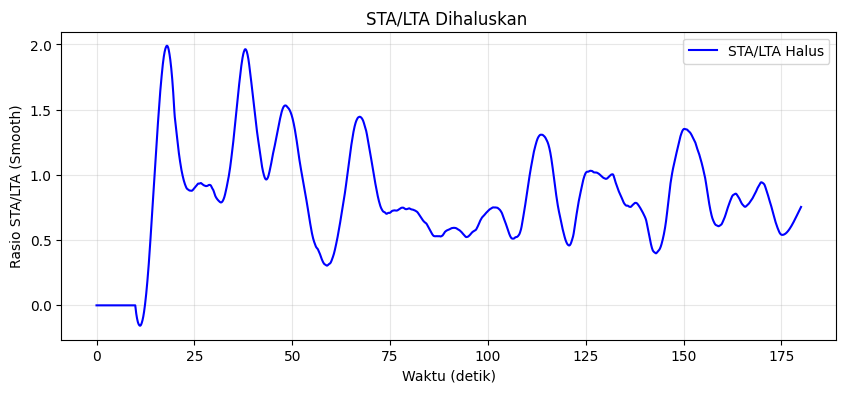

In [12]:
# Smoothing Hasil STA/LTA dengan Savitzky–Golay Filter

df = st_trim[0].stats.sampling_rate
cft = classic_sta_lta(st_trim[0].data, int(5 * df), int(15 * df))
cft_smooth = savgol_filter(cft, 201, 3)  # window 201 point, polinomial orde 3

plt.figure(figsize=(10,4))
plt.plot(st_trim[0].times(), cft_smooth, color='blue', label='STA/LTA Halus')
plt.xlabel("Waktu (detik)")
plt.ylabel("Rasio STA/LTA (Smooth)")
plt.title("STA/LTA Dihaluskan ")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("output/figures/03_sta_lta_smooth.png", dpi=200)
plt.show()


Setelah dilakukan proses penghalusan rasio STA/LTA, bentuk kurva menjadi lebih halus dan jelas dalam memperlihatkan perubahan energi sinyal seismik sepanjang waktu. Pada grafik, terlihat adanya tiga puncak utama antara detik ke-20 hingga 70, yang masing-masing menunjukkan peningkatan energi mendadak akibat kedatangan gelombang seismik. Puncak pertama sekitar detik ke-20–25 diinterpretasikan sebagai gelombang P (primer), yaitu gelombang pertama yang tiba di stasiun dengan energi relatif kecil dan periode pendek. Puncak-puncak berikutnya, khususnya di sekitar detik ke-40 dan 65, menandakan gelombang S (sekunder) yang datang beberapa detik setelah gelombang P, ditandai oleh amplitudo yang lebih besar dan osilasi yang lebih kuat. Dengan teknik smoothing ini, pola utama STA/LTA menjadi lebih mudah dibaca tanpa gangguan fluktuasi kecil akibat noise atau gangguan instrumen.

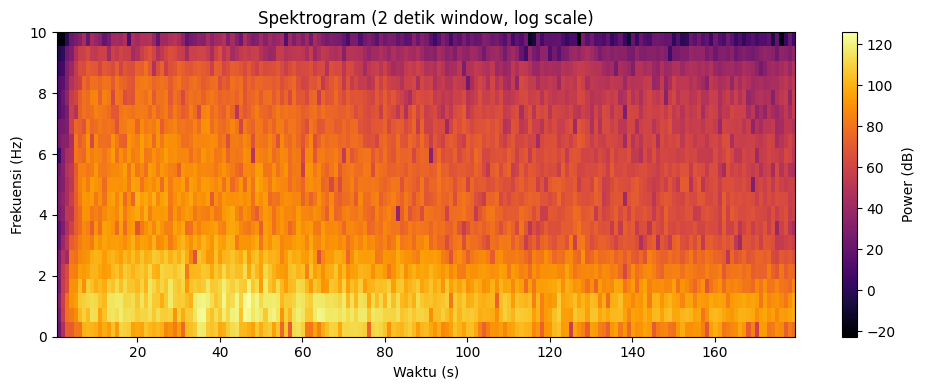

In [13]:
# Spektrogram dengan Skala Logaritmik Pada Data waveform
tr = st_trim[0].copy()
sr = tr.stats.sampling_rate
nfft = int(2*sr)

plt.figure(figsize=(10,4))
plt.specgram(tr.data, Fs=sr, NFFT=nfft, noverlap=nfft//2, cmap="inferno", scale="dB")
plt.colorbar(label="Power (dB)")
plt.title("Spektrogram (2 detik window, log scale)")
plt.xlabel("Waktu (s)")
plt.ylabel("Frekuensi (Hz)")
plt.tight_layout()
plt.savefig("output/figures/04_spectrogram.png", dpi=150)
plt.show()


Hasil dari spektrogram ini menyajikan distribusi energi sinyal seismik dalam domain waktu dan frekuensi. Sumbu horizontal menunjukkan waktu dalam detik (s) dari 0 hingga sekitar 180 detik, sumbu vertikal merepresentasikan frekuensi dalam Hertz (Hz) dari 0 hingga 10 Hz, dan skala warna di sebelah kanan menunjukkan tingkat kekuatan atau energi sinyal dalam desibel (dB). Warna yang lebih terang, seperti kuning, mengindikasikan energi sinyal yang paling tinggi, sedangkan warna yang lebih gelap menandakan energi yang lebih rendah. 
Dari visualisasi di atas, energi sinyal seismik yang paling signifikan terkonsentrasi pada rentang frekuensi yang sangat rendah, yaitu antara 0 hingga sekitar 2 Hz. Hal ini terlihat dari pita berwarna kuning cerah yang dominan di bagian bawah grafik sepanjang durasi rekaman. Energi sinyal ini tampak paling kuat pada awal rekaman (sekitar detik ke-10 hingga ke-40) dan kemudian perlahan-lahan menurun seiring berjalannya waktu, meskipun tetap menjadi komponen frekuensi yang paling dominan. Di frekuensi yang lebih tinggi (di atas 2 Hz), energi sinyal secara umum jauh lebih rendah, seperti yang ditunjukkan oleh warna oranye hingga ungu gelap, dan distribusinya terlihat lebih acak, yang kemungkinan besar merepresentasikan getaran latar belakang dengan energi yang lebih kecil.

### Mengambil rentang sampel untuk Trimming 10 detik

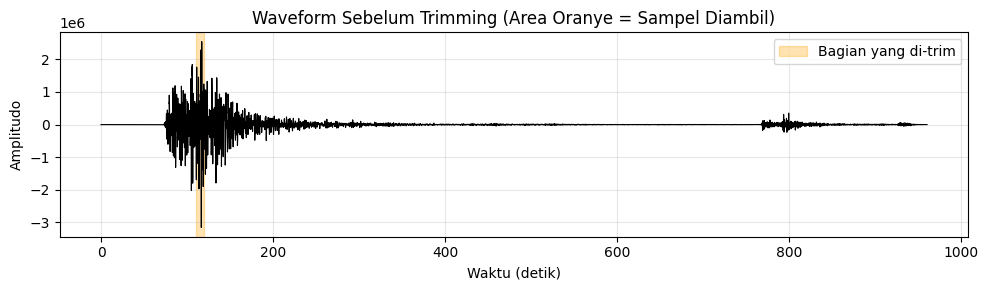

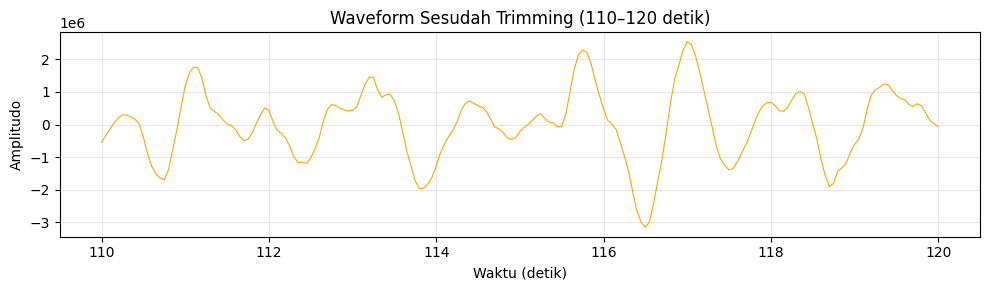

Data berhasil di-trim dari detik 110 sampai 120.


In [14]:
# Tentukan Rentang Waktu Trimming 
t_awal_detik = 110
t_akhir_detik = 120

# Duplikasi Stream
st_before = st_filt.copy()

# Hitung Waktu Absolut berdasarkan detik relatif
start_abs = st_filt[0].stats.starttime + t_awal_detik
end_abs   = st_filt[0].stats.starttime + t_akhir_detik

# Lakukan Trimming
st_trim1 = st_filt.copy().trim(start_abs, end_abs)

# Plot Sebelum Trimming
trb = st_before[0]
t1 = np.linspace(0, trb.stats.npts / trb.stats.sampling_rate, trb.stats.npts)
plt.figure(figsize=(10,3))
plt.plot(t1, trb.data, lw=0.8, color='black')
plt.axvspan(t_awal_detik, t_akhir_detik, color='orange', alpha=0.3, label='Bagian yang di-trim')
plt.title("Waveform Sebelum Trimming (Area Oranye = Sampel Diambil)")
plt.xlabel("Waktu (detik)")
plt.ylabel("Amplitudo")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("output/figures/05a_wafeform_in_trimming.png", dpi=200)
plt.show()

# Plot Sesudah Trimming
trt = st_trim1[0]
t2 = np.linspace(t_awal_detik, t_akhir_detik, trt.stats.npts)
plt.figure(figsize=(10,3))
plt.plot(t2, trt.data, lw=0.8, color="orange")
plt.title(f"Waveform Sesudah Trimming ({t_awal_detik}–{t_akhir_detik} detik)")
plt.xlabel("Waktu (detik)")
plt.ylabel("Amplitudo")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("output/figures/05b_wafeform_trimming.png", dpi=200)
plt.show()

print(f"Data berhasil di-trim dari detik {t_awal_detik} sampai {t_akhir_detik}.")


Dari visualisasi di atas, dapat diinterpretasikan bahwa segmen ini menangkap momen getaran tanah yang sangat intens. Amplitudo sinyal berfluktuasi secara signifikan, menunjukkan energi gempa yang besar pada rentang waktu ini. Puncak tertinggi dari getaran, yang merepresentasikan simpangan atau pergerakan tanah maksimum, terjadi pada sekitar detik ke-116,5. Pada titik ini, amplitudo mencapai nilai negatif terendah sekitar -3.1 x 10⁶. Bagian sinyal dengan amplitudo yang sangat besar seperti ini secara seismologis umumnya menandakan kedatangan Gelombang S (Sekunder) atau gelombang permukaan, yang membawa energi paling merusak dari sebuah gempa.

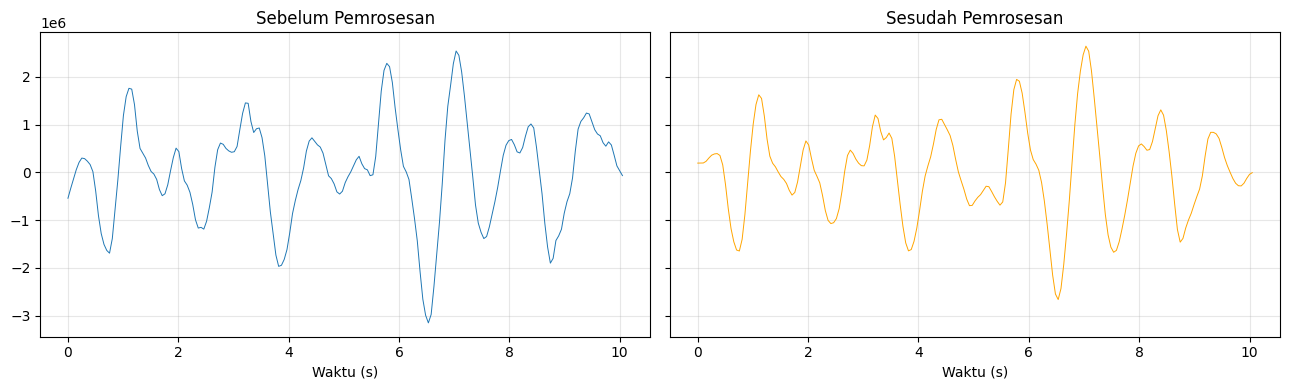

In [15]:
# Perbandingan Sebelum dan Sesudah Pemrosesan ulang
st_proc_before = st_trim1.copy()
st_proc_after  = st_trim1.copy()

st_proc_after.detrend("demean")
st_proc_after.taper(max_percentage=0.05, type="hann")
st_proc_after.filter("bandpass", freqmin=0.5, freqmax=5.0, corners=4, zerophase=True)

trb, tra = st_proc_before[0], st_proc_after[0]
tb = np.linspace(0, trb.stats.npts/trb.stats.sampling_rate, trb.stats.npts)
ta = np.linspace(0, tra.stats.npts/tra.stats.sampling_rate, tra.stats.npts)

fig, ax = plt.subplots(1,2,figsize=(13,4),sharey=True)
ax[0].plot(tb, trb.data, lw=0.7)
ax[0].set_title("Sebelum Pemrosesan")
ax[1].plot(ta, tra.data, lw=0.7, color="orange")
ax[1].set_title("Sesudah Pemrosesan")
for a in ax:
    a.set_xlabel("Waktu (s)")
    a.grid(alpha=0.3)
plt.tight_layout()
fig.savefig("output/figures/06_proc_compare.png", dpi=150)
plt.show()


- Sebelum Pemrosesan (Grafik Kiri) <br>
Sinyal asli (biru) menunjukkan adanya baseline drift atau tren frekuensi rendah. Ini terlihat dari osilasi sinyal yang tidak berpusat pada garis amplitudo nol. Amplitudo rata-rata sinyal ini berada di atas nol, yang merupakan artifak atau gangguan dalam data mentah yang dapat mengaburkan fitur seismik sebenarnya. <br> <br>
- Sesudah Pemrosesan (Grafik Kanan) <br>
Setelah diproses (oranye), sinyal kini berpusat di sekitar garis amplitudo nol. Ini menunjukkan bahwa langkah-langkah pemrosesan seperti detrend (menghilangkan tren linier) dan demean (menghilangkan nilai rata-rata) telah berhasil diterapkan. Selain itu, sinyal mungkin juga telah melalui proses tapering, yang menghaluskan bagian awal dan akhir sinyal untuk mencegah distorsi pada analisis frekuensi. <br> <br>
Namun Jika dilihat kembali nilai puncak dari sinyal setelah mengalami pemrosesan /filtering ulang menjadi menurun dan lebih kecil dari sebelumnya walaupun tingkat penurunannya tidak terlalu signifikan namun ini bisa saja mengakibatkan kesalahan saat analisis data lebih lanjut


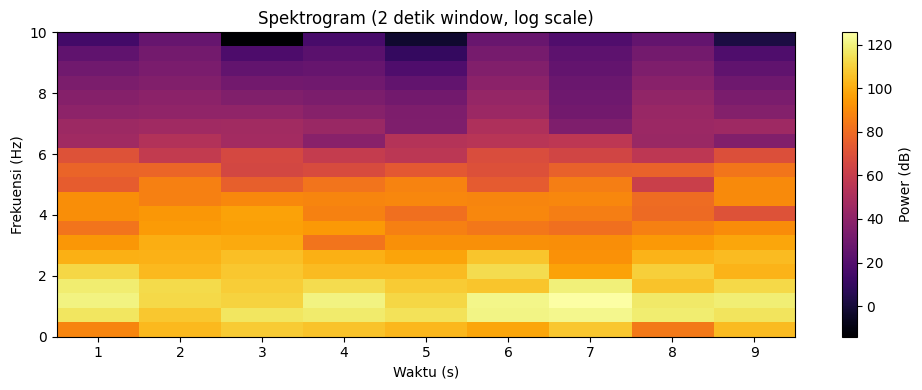

In [16]:
# Spektrogram dengan Skala Logaritmik Pada Data Setelah Pemrosesan Ulang
tr = st_proc_after[0].copy()
sr = tr.stats.sampling_rate
nfft = int(2*sr)  # window 2 detik

plt.figure(figsize=(10,4))
plt.specgram(tr.data, Fs=sr, NFFT=nfft, noverlap=nfft//2, cmap="inferno", scale="dB")
plt.colorbar(label="Power (dB)")
plt.title("Spektrogram (2 detik window, log scale)")
plt.xlabel("Waktu (s)")
plt.ylabel("Frekuensi (Hz)")
plt.tight_layout()
plt.savefig("output/figures/07_spectrogram_after_trimming.png", dpi=150)
plt.show()


Spektrogram ini menunjukkan distribusi energi sinyal seismik selama periode 10 detik. Dari visualisasi tersebut, terlihat jelas bahwa energi sinyal paling kuat terkonsentrasi pada rentang frekuensi rendah, khususnya antara 0 hingga 2 Hz, yang ditandai oleh pita berwarna kuning cerah di bagian bawah grafik. Energi yang cukup signifikan juga terlihat hingga sekitar 6 Hz, namun menurun drastis pada frekuensi yang lebih tinggi, seperti yang ditunjukkan oleh warna ungu dan hitam. Secara temporal, energi tinggi di frekuensi rendah ini bertahan sepanjang durasi rekaman dengan beberapa puncak intensitas, terutama di sekitar detik ke-2 dan ke-6. Pola ini mengindikasikan bahwa getaran yang terekam memiliki karakteristik dominan frekuensi rendah, yang merupakan ciri khas dari gelombang seismik.

 Membuat peta lokasi stasiun ...


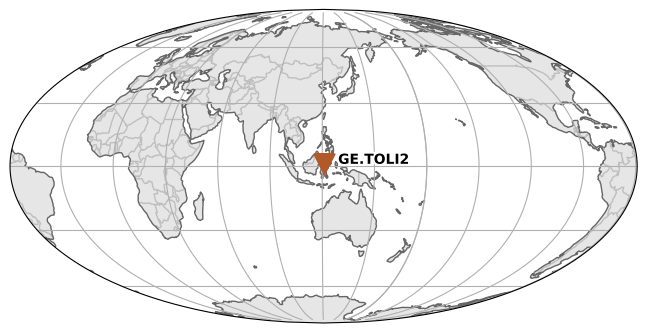

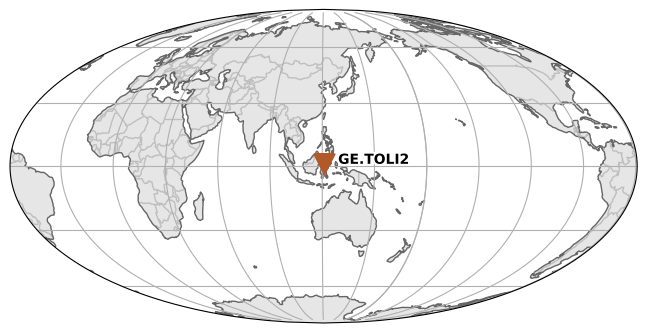

In [17]:
#  Peta Lokasi Stasiun
print(" Membuat peta lokasi stasiun ...")
inv_net = client.get_stations(network=network, station=station, level="station")
inv_net.plot(outfile="output/figures/08_station_map.png", projection="global")

Gambar ini menampilkan peta global yang menunjukkan lokasi stasiun seismik GE.TOLI2, yang ditandai dengan simbol segitiga terbalik berwarna oranye. Stasiun ini terletak di Sulawesi Tengah, Indonesia. Peta ini memberikan konteks geografis yang penting untuk analisis, mengonfirmasi bahwa data seismik yang digunakan berasal dari stasiun yang lokasinya relatif dekat dengan episentrum gempa Palu 2018 dan stasiun ini memiliki kedekatan sekitar 167 km dari lokasi gempa. Kedekatan ini memastikan bahwa sinyal yang terekam memiliki kualitas yang baik dan dapat diandalkan untuk menganalisis karakteristik gelombang gempa secara detail.

## Kesimpulan 
<br> 
Berdasarkan hasil analisis data yang telah dilakukan, didapatkan berbagai kesimpulan yaitu <br> <br>
- Stasiun GE.TOLI2 berlokasi di Sulawesi Tengah dengan jarak sekitar 176.9 km dari episentrum Gempa Palu 2018. Kedekatan ini memastikan bahwa data yang terekam memiliki intensitas sinyal tinggi dan representatif untuk analisis karakteristik gelombang gempa. Peta lokasi membantu memahami posisi stasiun terhadap sumber dan arah rambatan gelombang.<br> <br>
- Waveform yang masih belum diproses menunjukkan banyak gangguan noise dengan amplitudo acak yang sulit diinterpretasikan. Setelah dilakukan tahapan detrend, tapering, dan filtering berhasil menormalkan sinyal sehingga sinyal menjadi lebih bersih dan lebih mudah dianalisis serta pola gelombang gempa tampak jelas. Hasil trimming pada detik ke-70–250 memperlihatkan peningkatan amplitudo yang menandakan kedatangan gelombang utama, yaitu fase gelombang P dan S. <br> <br>
- Metode STA/LTA berhasil mendeteksi tiga onset utama yang menggambarkan momen perubahan energi signifikan dalam sinyal. Onset pertama (10:03:24 UTC) diidentifikasi sebagai gelombang P, sementara onset kedua dan ketiga (10:03:46–10:04:18 UTC) menunjukkan gelombang S yang membawa energi lebih besar. Hasil ini sesuai dengan teori bahwa gelombang P selalu tiba lebih awal dibanding gelombang S. 
- Hasil dari Spektrogram menunjukkan bahwa energi sinyal paling kuat berada pada frekuensi rendah, antara 0–2 Hz, yang merupakan ciri khas gelombang gempa bumi. Energi tertinggi muncul di awal hingga pertengahan rekaman dan menurun perlahan pada akhir sinyal. Frekuensi tinggi di atas 2 Hz menunjukkan energi yang lebih lemah dan didominasi noise.
<br> <br>
Secara keseluruhan, analisis sinyal menggunakan ObsPy berhasil menggambarkan karakteristik propagasi gelombang gempa secara komprehensif. Gelombang P muncul lebih awal dengan amplitudo yang lebih kecil, dan diikuti oleh gelombang S yang lebih kuat pada frekuensi rendah. Proses filtering, STA/LTA, dan spektrogram menunjukkan efektivitas metode analisis ini dalam mendeteksi, memvisualisasikan, dan menginterpretasikan sinyal seismik secara ilmiah
